# Analysis of an `opsim4` run `des70_2012`

## Juypter boilerplate

### Basic notebook configuration

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Base python modules

In [3]:
import sys
import os

### Standard scientific python stuff

In [4]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy

### Set plotting style

In [5]:
mpl.rcParams['figure.figsize'] = (10, 5)
plt.style.use('ggplot')

### LSST specific modules

In [6]:
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

lsst.sims.maf.__version__

'2.4.0.sims-13-gc7b79bd'

## Configuration

Set the random number seed so the notebook is strictly repeatable:

In [7]:
np.random.seed(6563)

Paths:

In [8]:
sim_db_path = '/home/docmaf/run_local/output'
base_results_path = '/home/docmaf/run_local/maf_results'

## Compare seeing histories of the new and default simulations

### Supporting code

Create a "year stacker" so I can use it to plot the seeing history with a scale of years:

In [9]:
class YearStacker(stackers.BaseStacker):
    """Calculate the floating point years into the survey."""
    def __init__(self):
        self.units = ['years']
        self.colsAdded = ['years_into_survey']
        self.colsReq = ['night']
        
    def run(self, simData):
        """Calculate new column years into the survey."""
        simData=self._addStackers(simData)
        simData['years_into_survey'] = simData['night'].astype(float)/365.24
        return simData

Create a procedure for plotting the seeing with time:

In [10]:
def plot_seeing_vs_year(dbname):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    seeing_metric = metrics.MeanMetric('seeingFwhm500')
    year_slicer = slicers.OneDSlicer('years_into_survey', 'years', 12*10)
    mean_seeing = metricBundles.MetricBundle(seeing_metric, year_slicer, stackerList=[YearStacker()])
    mean_seeing_bundle = {'mean_seeing': mean_seeing}
    mean_seeing_group = metricBundles.MetricBundleGroup(mean_seeing_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    mean_seeing_group.runAll()
    
    mean_seeing_group.plotAll(closefigs=False)

### Base simulation seeing history

Querying database SummaryAllProps with no constraint for columns ['night', 'seeingFwhm500'].
Found 2364976 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


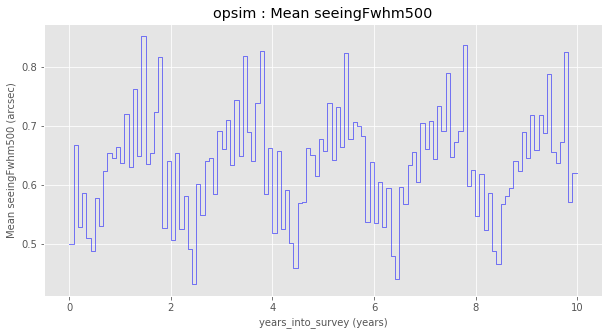

In [11]:
plot_seeing_vs_year('des70_2001')

### Simulation with remodeled seeing

Querying database SummaryAllProps with no constraint for columns ['night', 'seeingFwhm500'].
Found 2341351 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


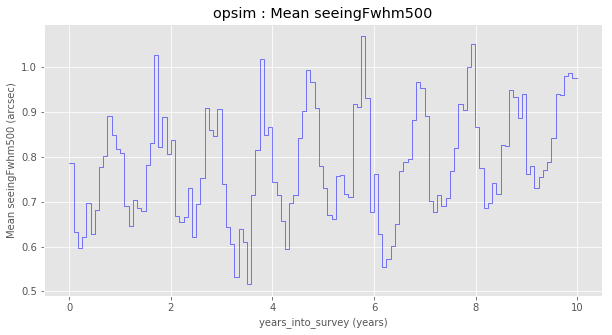

In [12]:
plot_seeing_vs_year('des70_2013')

## Add extinction from clouds to the simulation with remodeled seeing

### Apply a constant extinction for each cloud level

Following extinction values derived from the t<sub>eff</sub> values in <a href='https://www.osti.gov/biblio/1250881/'>FERMILAB-FN-2002-AE-CD</a>, apply a constant extintion for each cloud level. In the note, the extinction for cloud level 3 was higher than that for 4, which is unphysical, and the two values were close. Therefore, I apply the mean of the two for both.

~~~~
des70 4323$ cd /data/des70.a/data/neilsen/opsim4_data/run_local/output
des70 4325$ cp des70_2013.db des70_2013_plusclouds.db
des70 4327$ sqlite3 des70_20113_plusclouds.db
SQLite version 3.9.2 2015-11-02 18:31:45
Enter ".help" for usage hints.
sqlite> UPDATE ObsHistory SET fiveSigmaDepth=fiveSigmaDepth-0.21 WHERE ROUND(8*cloud)=1;
sqlite> UPDATE ObsHistory SET fiveSigmaDepth=fiveSigmaDepth-0.23 WHERE ROUND(8*cloud)=2;
sqlite> UPDATE ObsHistory SET fiveSigmaDepth=fiveSigmaDepth-0.31 WHERE ROUND(8*cloud)=3;
sqlite> UPDATE ObsHistory SET fiveSigmaDepth=fiveSigmaDepth-0.31 WHERE ROUND(8*cloud)=4;
sqlite> UPDATE ObsHistory SET fiveSigmaDepth=fiveSigmaDepth-0.67 WHERE ROUND(8*cloud)=5;
sqlite> UPDATE ObsHistory SET fiveSigmaDepth=fiveSigmaDepth-0.87 WHERE ROUND(8*cloud)=6;
sqlite> .q

~~~~

## Map the seeing in the different simulations

### Supporting code

In [13]:
def map_seeing(dbname,
              sql_constraint = 'filter = "i" AND proposalId=3',
              metric=metrics.MeanMetric,
             ):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('seeingFwhmEff')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'seeingFwhmEff': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()
    
    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.seeingFwhmEff.describe())
    
    metric_group.plotAll(closefigs=False)

### Base simulation FWHM map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fieldRA', 'seeingFwhmEff']
Found 444817 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444817.000000
mean          0.858629
std           0.184589
min           0.484656
25%           0.727346
50%           0.829340
75%           0.959636
max           1.899399
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
monopole: 0.874962  dipole: lon: -67.515, lat: 69.3421, amp: 0.0392962
Plotting complete.


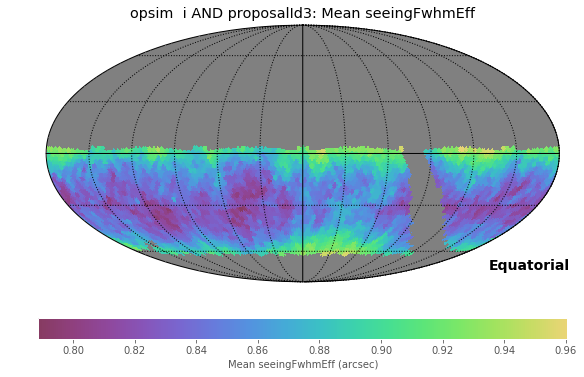

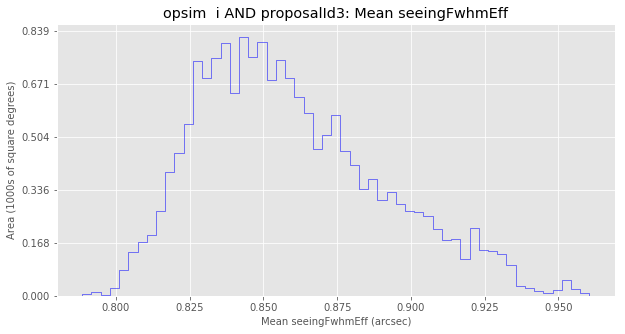

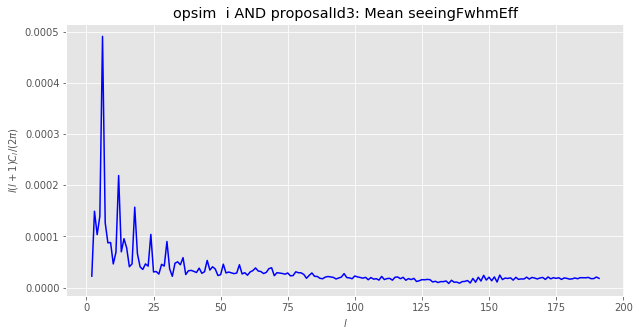

In [14]:
map_seeing('des70_2001')

### Remodeled seeing FWHM map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fieldRA', 'seeingFwhmEff']
Found 438999 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    438999.000000
mean          0.968397
std           0.245194
min           0.470256
25%           0.780565
50%           0.922020
75%           1.116746
max           2.709761
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
monopole: 1.00197  dipole: lon: -60.9811, lat: 37.2182, amp: 0.117529
Plotting complete.


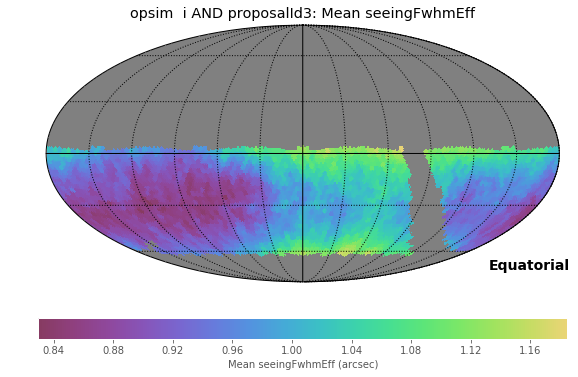

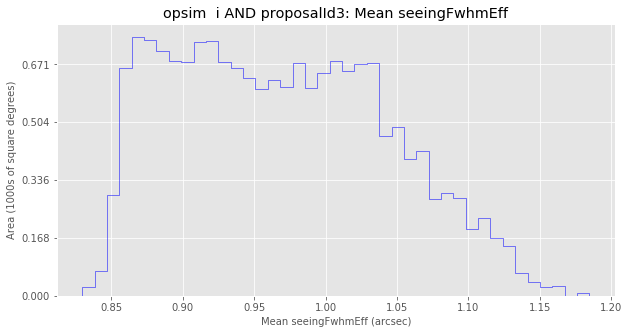

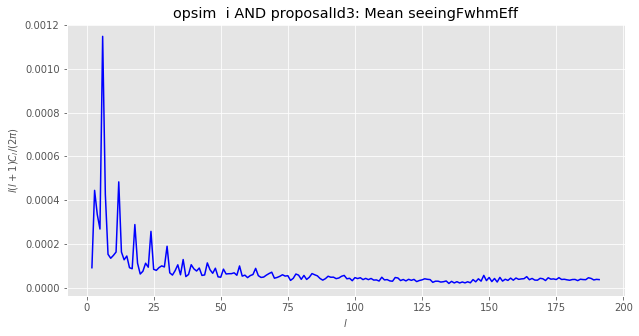

In [15]:
map_seeing('des70_2013')

## Compare the depths of the different simulations

### Supporting code

In [16]:
def map_depth(dbname,
              sql_constraint = 'filter = "i" AND proposalId=3',
              metric=metrics.MeanMetric,
             ):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('fiveSigmaDepth')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'depth': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()

    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.fiveSigmaDepth.describe())

    metric_group.plotAll(closefigs=False)

### Base simulation depth map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth']
Found 444817 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444817.000000
mean         23.668003
std           0.258342
min          22.533697
25%          23.500659
50%          23.683083
75%          23.849958
max          24.382914
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
monopole: 23.6373  dipole: lon: 102.639, lat: -72.0556, amp: 0.0729525
Plotting complete.


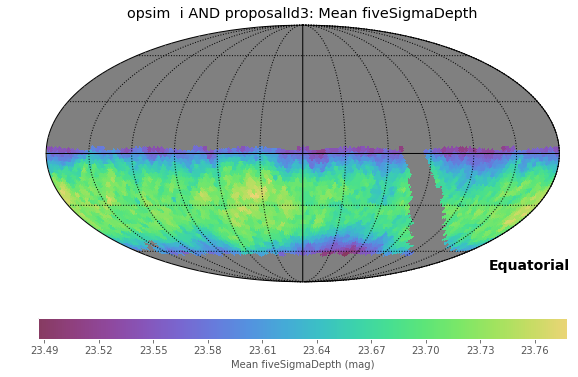

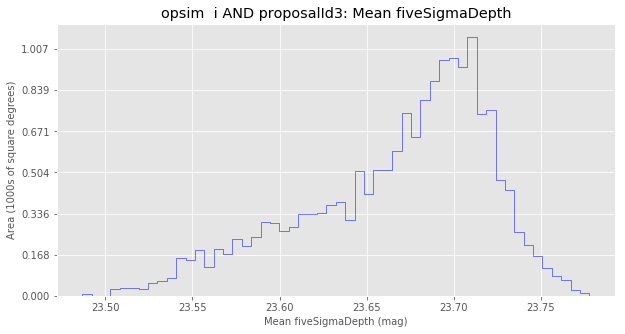

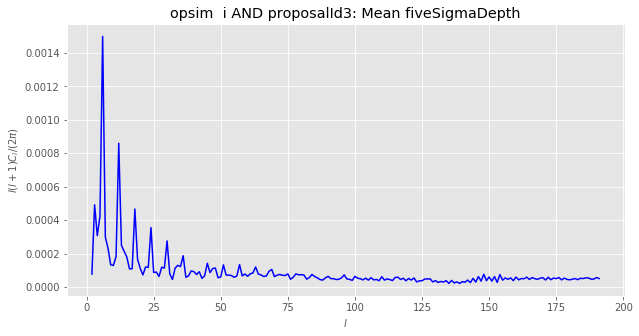

In [18]:
map_depth('des70_2001')

### Remodeled seeing depth map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth']
Found 438999 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    438999.000000
mean         23.549388
std           0.298824
min          22.306386
25%          23.343629
50%          23.564600
75%          23.769396
max          24.410374
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
monopole: 23.502  dipole: lon: 112.762, lat: -43.5851, amp: 0.148071
Plotting complete.


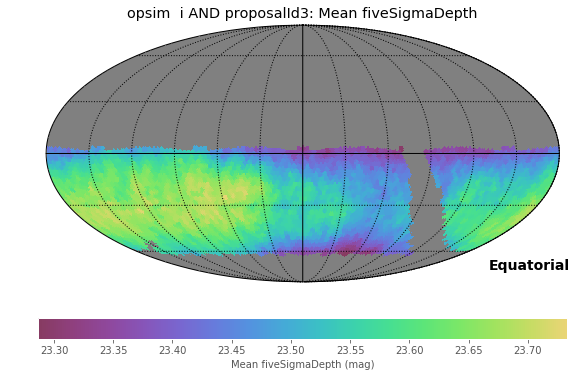

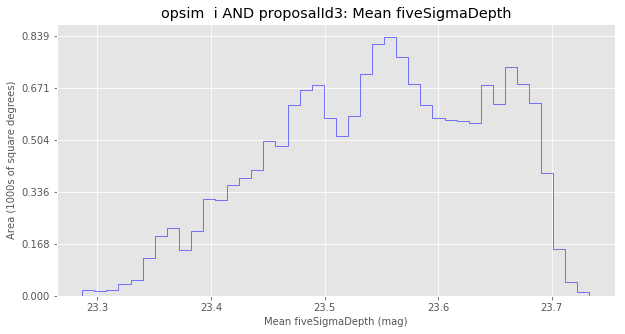

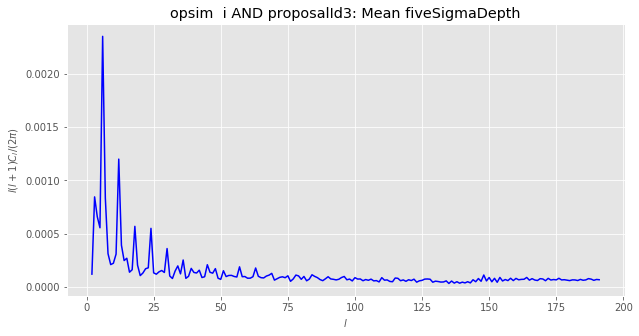

In [20]:
map_depth('des70_2013')

### Remedeled seeing with constant cloud extinction depth map

#### Clouds added using post-processing

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth']
Found 438999 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    438999.000000
mean         23.449693
std           0.349055
min          21.833239
25%          23.217523
50%          23.473685
75%          23.705411
max          24.382380
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
monopole: 23.3961  dipole: lon: 113.032, lat: -36.0351, amp: 0.191808
Plotting complete.


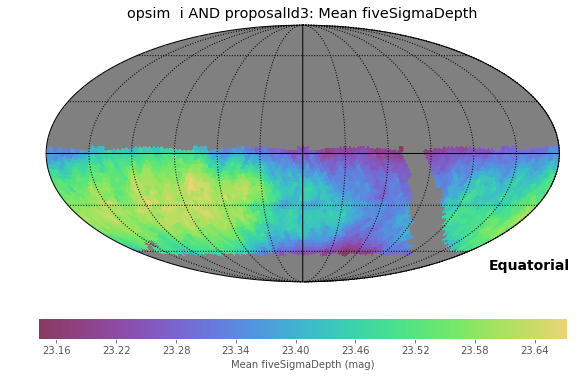

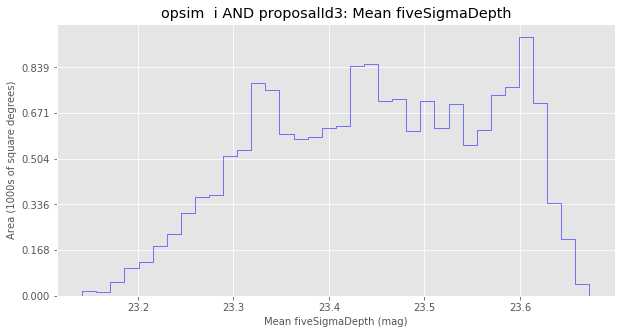

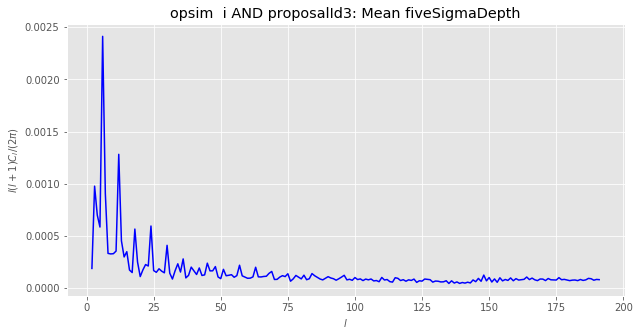

In [22]:
map_depth('des70_2013_plusclouds')

## Plotting depth and seeing with field R.A.

### Support code

Load data into `pandas.DataFrame`s.

In [23]:
def load_df(dbname,
            metric_columns = ['seeingFwhmEff', 'fiveSigmaDepth'],
            slice_column = 'fieldRA',
            sql_constraint = 'filter = "i" AND proposalId=3',
            agg_metric=metrics.MeanMetric):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    slicer_for_df = slicers.OneDSlicer(slice_column)
    metric_bundle = {col: metricBundles.MetricBundle(agg_metric(col), slicer_for_df, sql_constraint)
                     for col in metric_columns}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    metric_group.runAll()
    df = pd.DataFrame.from_records(metric_group.simData)
    df.sort_values('fieldRA', inplace=True)
    df['hour'] = np.floor(df.fieldRA/15).astype(np.int32)
    return df

### Load the data

In [26]:
base_by_ra = load_df('des70_2001')
newsee_by_ra = load_df('des70_2013')
constcloud_by_ra = load_df('des70_2013_plusclouds')
#randcloud_by_ra = load_df('des70_2006_plus_rand_clouds')

Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldRA', 'seeingFwhmEff', 'fiveSigmaDepth']
Found 444817 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 4.655531 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldRA', 'seeingFwhmEff', 'fiveSigmaDepth']
Found 438999 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 4.716788 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldRA', 'seeingFwhmEff', 'fiveSigmaDepth']
Found 438999 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Plot depth against R.A.

Text(0,0.5,'mean 5$\\sigma$ depth')

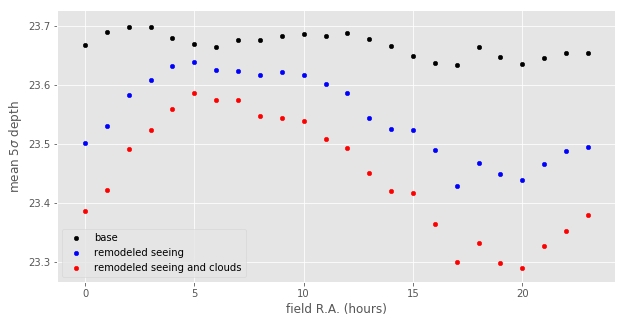

In [27]:
fig, axes = plt.subplots()
base_by_ra.groupby(base_by_ra.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c='k', label='base', ax=axes)
newsee_by_ra.groupby(newsee_by_ra.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c='b', label='remodeled seeing', ax=axes)
constcloud_by_ra.groupby(constcloud_by_ra.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c='r', label='remodeled seeing and clouds', ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean 5$\sigma$ depth')

What is the difference between the base and the revisions?

In [28]:
print("Difference between base and remodeled seeing: ",
     np.round(base_by_ra.fiveSigmaDepth.mean()-newsee_by_ra.fiveSigmaDepth.mean(), 2))
print("Difference between base and remodeled seeing with constant cloud extinction: ",
     np.round(base_by_ra.fiveSigmaDepth.mean()-constcloud_by_ra.fiveSigmaDepth.mean(), 2))

Difference between base and remodeled seeing:  0.12
Difference between base and remodeled seeing with constant cloud extinction:  0.22


What's the difference between the worst and best sets of months?

In [29]:
print('Difference in base: ', np.round(base_by_ra.query('4 <= hour <= 9').fiveSigmaDepth.mean() - base_by_ra.query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))
print('Difference in remodeled seeing simulation: ', np.round(newsee_by_ra.query('4 <= hour <= 9').fiveSigmaDepth.mean() - newsee_by_ra.query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))
print('Difference in remodeled seeing with clouds simulation: ', np.round(constcloud_by_ra.query('4 <= hour <= 9').fiveSigmaDepth.mean() - constcloud_by_ra.query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))

Difference in base:  0.03
Difference in remodeled seeing simulation:  0.17
Difference in remodeled seeing with clouds simulation:  0.25


What are these in decimal degrees?

In [30]:
np.array([4, 9+1, 16, 21+1])*15

array([ 60, 150, 240, 330])

### Plot delivered FWHM against R.A.

Text(0,0.5,'mean seeingFwhmEff')

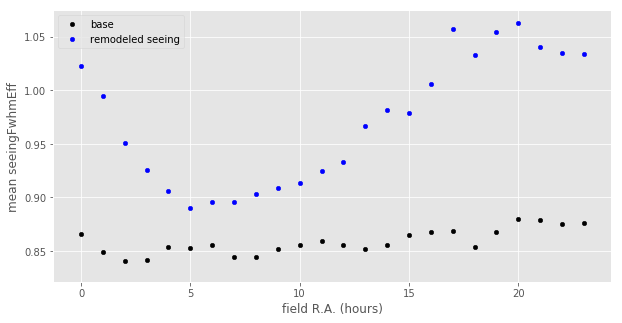

In [31]:
fig, axes = plt.subplots()
base_by_ra.groupby(base_by_ra.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c='k', label='base', ax=axes)
newsee_by_ra.groupby(newsee_by_ra.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c='b', label='remodeled seeing', ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean seeingFwhmEff')

In [32]:
print("Difference between base and remodeled seeing: ",
     np.round((base_by_ra.seeingFwhmEff.mean()-newsee_by_ra.seeingFwhmEff.mean())/base_by_ra.seeingFwhmEff.mean(), 2))

Difference between base and remodeled seeing:  -0.13


In [33]:
print('Difference in base: ', np.round( (base_by_ra.query('16 <= hour <= 22').seeingFwhmEff.mean() - base_by_ra.query('4 <= hour <= 10').seeingFwhmEff.mean())/base_by_ra.query('4 <= hour <= 10').seeingFwhmEff.mean(), 2))
print('Difference in remodeled seeing simulation: ', np.round( (newsee_by_ra.query('16 <= hour <= 22').seeingFwhmEff.mean() - newsee_by_ra.query('4 <= hour <= 10').seeingFwhmEff.mean())/newsee_by_ra.query('4 <= hour <= 10').seeingFwhmEff.mean(), 2))

Difference in base:  0.02
Difference in remodeled seeing simulation:  0.16
